In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import arviz as az
from celerite2 import terms as cterms
from celerite2 import GaussianProcess as cGaussianProcess
from celerite2.jax import GaussianProcess, terms
import chirp
import jax
import jax.lax
import jax.numpy as jnp
import jax.scipy.linalg as jsl
import jax.scipy.special as jsp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC, DiscreteHMCGibbs
import pandas as pd
import seaborn as sns
import xarray as xr

numpyro.set_host_device_count(10)

celerite2.jax only works with dtype float64. We're enabling x64 now, but you might run into issues if you've already run some jax code.
You can squash this warning by setting the environment variable 'JAX_ENABLE_X64=True' or by running:
>>> from jax import config
>>> config.update('jax_enable_x64', True)


We are trying to simulate several years of observations of a signal that has a true chirp with a frequency of (say) $6 \, \mathrm{yr}^{-1}$, superimposed on a DRW signal also with a time constant of $1/6 \, \mathrm{yr}$, whose RMS amplitudes are similar.  (Because the chirp is coherent, this means that it will have a *massive* SNR in these data.)

Observations are taken on average once every three days (but with several hours of random jitter); we randomly censor $1/3$ of these observations (local conditions?), and also three months out of each year (the object is too close to the sun to observe).  Observational uncertainties are about $10\%$ of the RMS variation of the DRW signal, but vary from observation to observation.

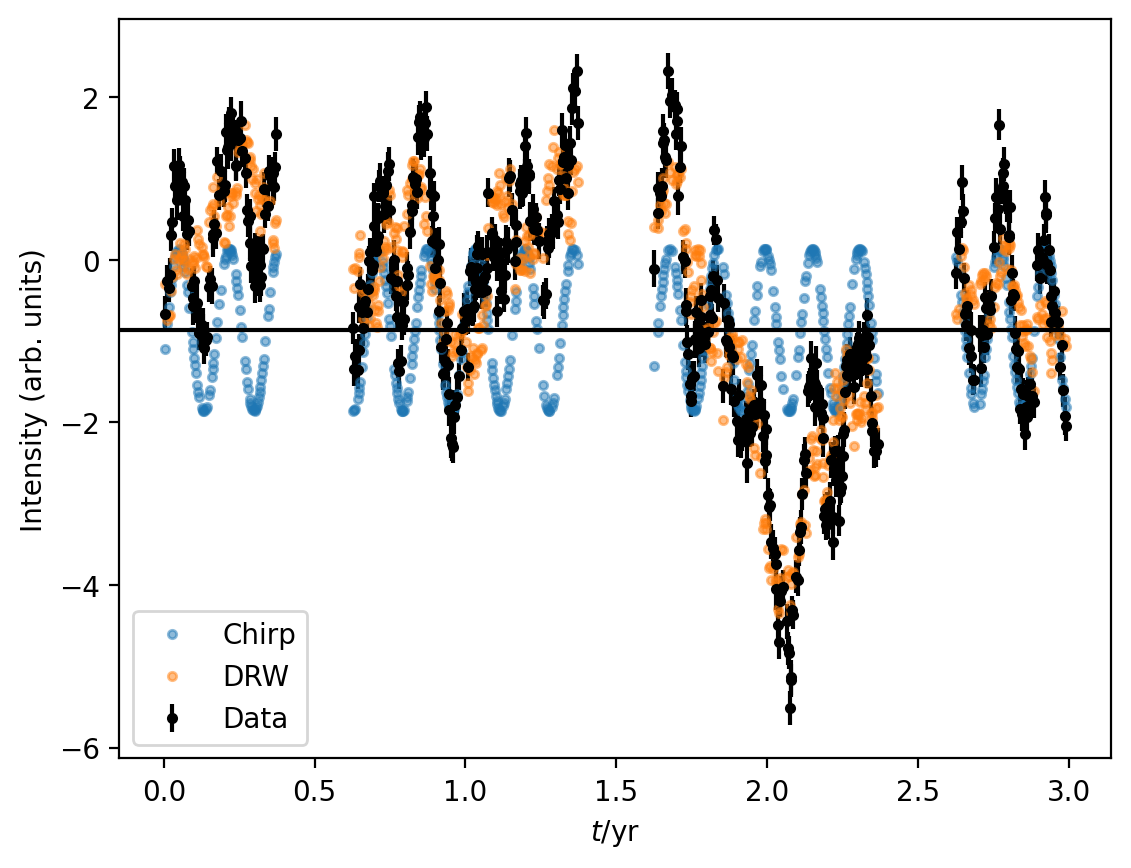

In [3]:
year = 1.0
day = 1.0/365.25
hour = day / 24.0
minute = hour / 60.0
second = minute / 60.0

T = 3*year

drop_out_fraction = 1/3

drw_amp = 1.0 
drw_tau = 1/6 * year

mean_uncert = 0.2
sd_log_uncert = 0.1

mu_true = np.random.normal(0,1)

# These are chosen so that the chirp time is ~15 years in the future---the mass is in funny units to ensure this!
chirp_f0 = 6 / year
chirp_w0 = 2*np.pi*chirp_f0
chirp_wdot = 0.08*chirp_w0 / T
chirp_mass, chirp_time = chirp.frequency_frequency_derivative_to_mc_tc(chirp_w0, chirp_wdot)
chirp_amp = 1.0
chirp_a, chirp_b = np.random.normal(0, 1, size=2)
r = np.sqrt(chirp_a**2 + chirp_b**2)
chirp_a = chirp_amp * chirp_a / r
chirp_b = chirp_amp * chirp_b / r

ts = np.arange(0, 3*year, day)
ts += np.random.uniform(-3*hour, 3*hour, size=ts.shape[0])
ts = ts[np.abs(ts % year - 0.5*year) > 0.25*year/2]
r = np.random.uniform(0, 1, size=ts.shape[0])
ts = ts[r > drop_out_fraction]

T = ts[-1] - ts[0]
t_grid = np.arange(ts[0]-T/4, ts[-1]+T/4, day)

tmid = np.median(ts)

chirp_wmid = chirp.chirp_frequency(tmid, chirp_time, chirp_mass)
chirp_wdotmid = chirp.chirp_frequency_derivative(tmid, chirp_time, chirp_mass)

drw_kernel = cterms.RealTerm(a=drw_amp*drw_amp, c=1/drw_tau)
drw_process = cGaussianProcess(kernel=drw_kernel, mean=0.0)

chirp_signal = chirp.chirp(ts - tmid, chirp_a, chirp_b, chirp_time - tmid, chirp_mass)
drw_process.compute(ts)
drw_signal = drw_process.sample()
obs_uncert = np.random.lognormal(mean=np.log(mean_uncert), sigma=sd_log_uncert, size=ts.shape[0])
obs_noise = np.random.normal(loc=0, scale=obs_uncert)

data = chirp_signal + drw_signal + obs_noise + mu_true

plt.errorbar(ts, data, yerr=obs_uncert, fmt='.', color='k', label='Data')
plt.plot(ts, chirp_signal + mu_true, '.', label='Chirp', alpha=0.5)
plt.plot(ts, drw_signal + mu_true, '.', label='DRW', alpha=0.5)
plt.axhline(mu_true, color='k')
plt.xlabel(r'$t / \mathrm{yr}$')
plt.ylabel(r'Intensity (arb. units)')
plt.legend(loc='best')

In [4]:
from importlib import reload
reload(chirp)

<module 'chirp' from '/Users/wfarr/Research/DRWChirp/chirp.py'>

In [16]:
nuts_kernel = NUTS(chirp.drw_chirp_model, dense_mass=True)
kernel = DiscreteHMCGibbs(nuts_kernel) # , random_walk=True)
sampler = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=4)

wbounds = (chirp_wmid/2, chirp_wmid*2)
wdotbounds = (chirp_wdotmid/2, chirp_wdotmid*2)

((w0, nw), (wdot0, nwdot)) = chirp.frequency_frequencydot_bounds_to_gridsize(wbounds, wdotbounds, T)

sampler_args = (ts, data, obs_uncert, (w0, nw), (wdot0, nwdot))
sampler_kwargs = dict(t_grid=t_grid)

sampler.run(jax.random.PRNGKey(np.random.randint(1<<32)), *sampler_args, **sampler_kwargs)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [17]:
trace = chirp.from_numpyro_with_generated_quantities(sampler, *sampler_args, **sampler_kwargs)

array([[<Axes: ylabel='log_tau'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='wmid'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='log_drw_amp', ylabel='wdotmid'>,
        <Axes: xlabel='log_tau'>, <Axes: xlabel='wmid'>]], dtype=object)

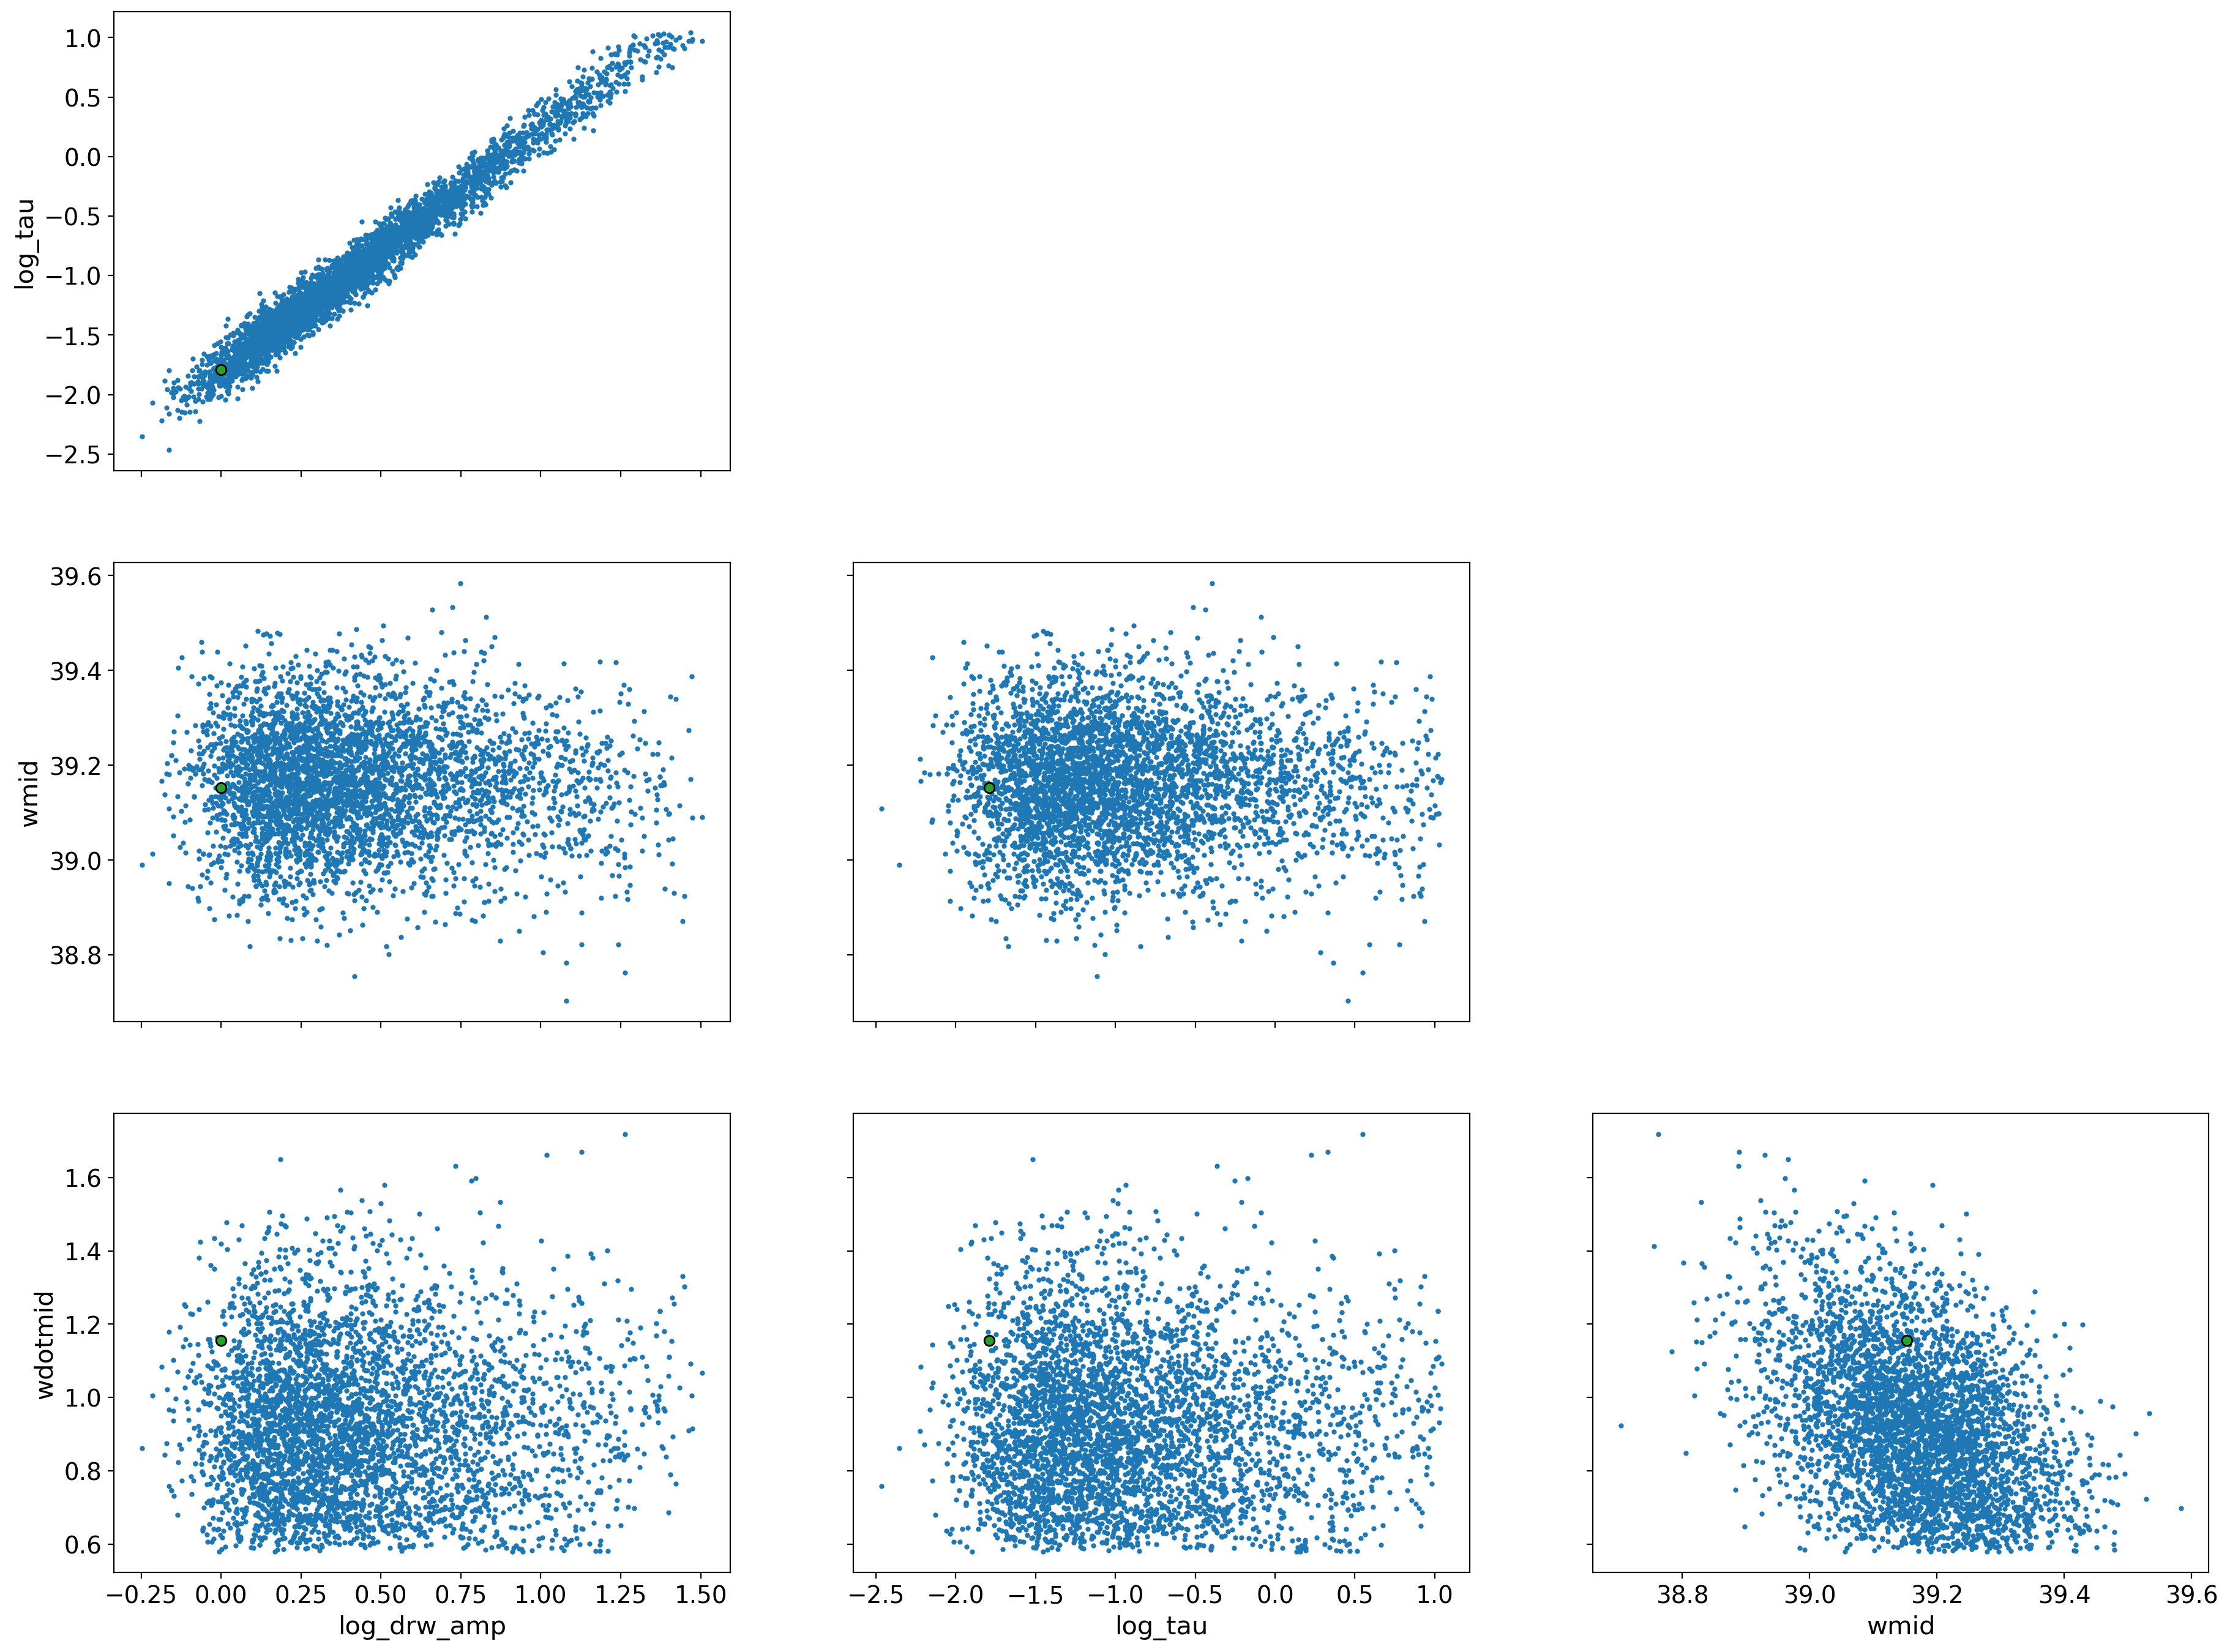

In [18]:
az.plot_pair(trace, var_names=['log_drw_amp', 'log_tau', 'wmid', 'wdotmid'],
             reference_values={'log_drw_amp': np.log(drw_amp), 'log_tau': np.log(drw_tau), 'wmid': chirp_wmid, 'wdotmid': chirp_wdotmid})

array([[<Axes: ylabel='wdotmid'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='a'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='wmid', ylabel='b'>, <Axes: xlabel='wdotmid'>,
        <Axes: xlabel='a'>]], dtype=object)

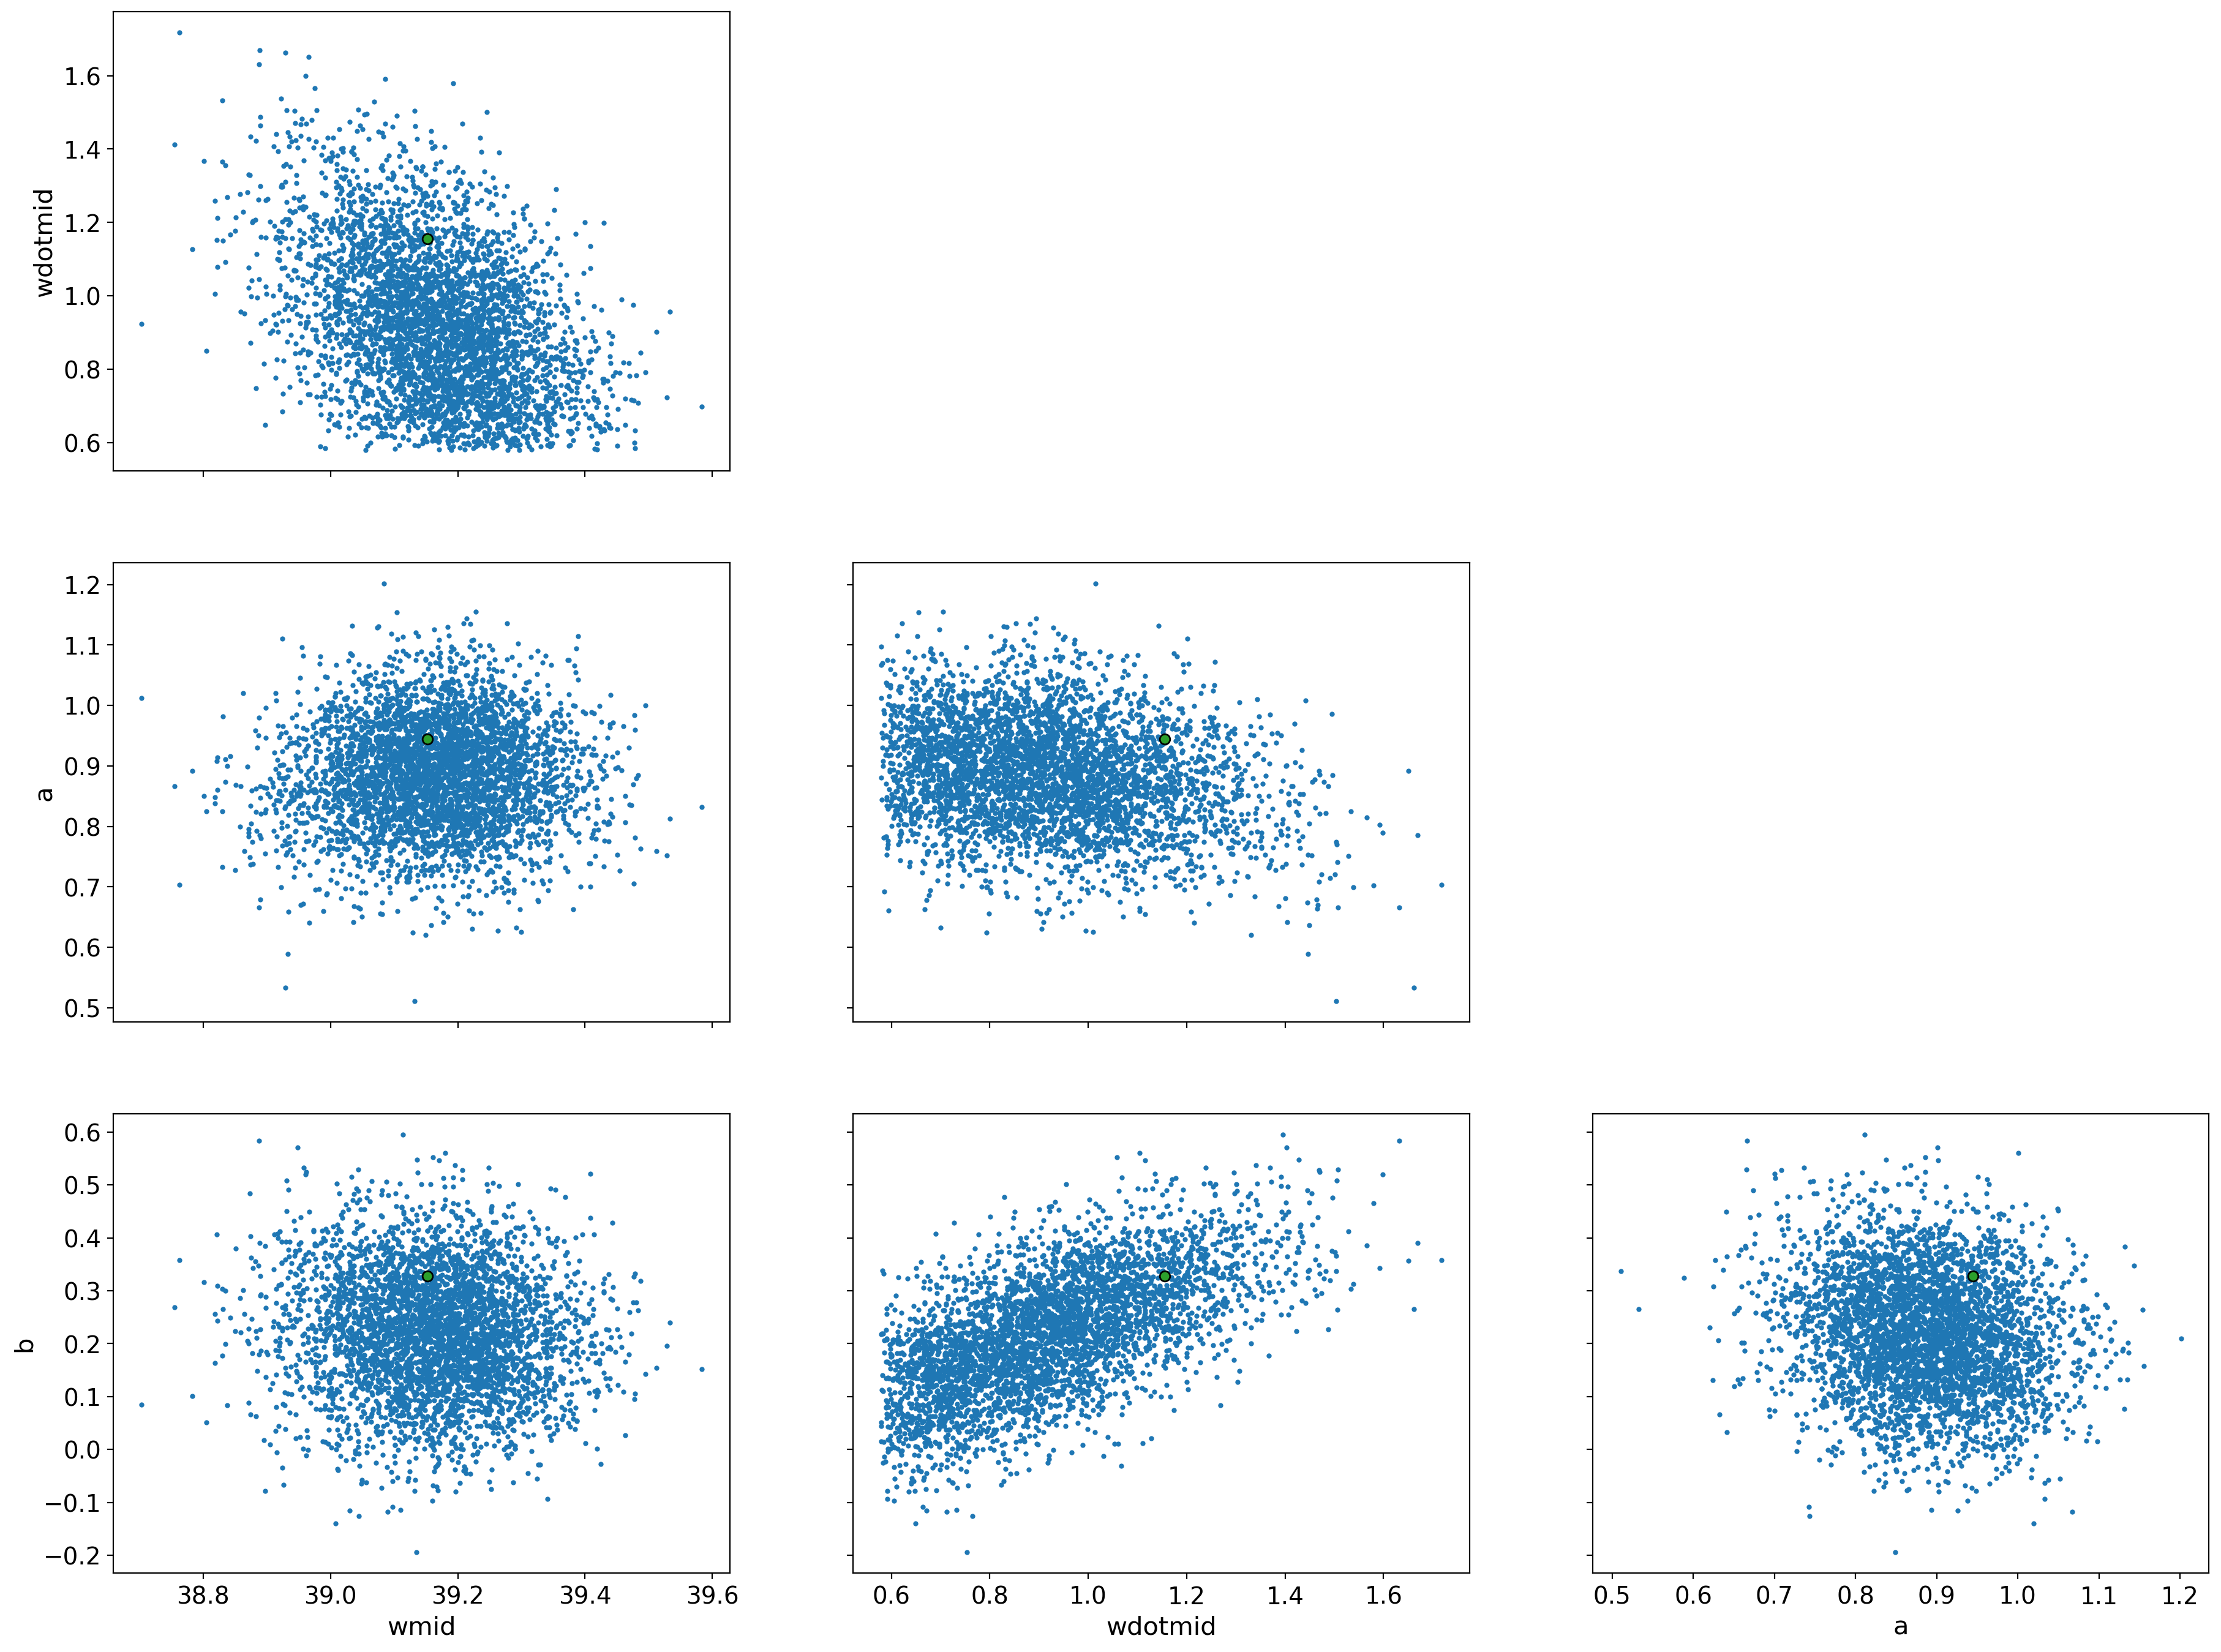

In [19]:
az.plot_pair(trace, var_names=['wmid', 'wdotmid', 'a', 'b'],
             reference_values={'wmid': chirp_wmid, 'wdotmid': chirp_wdotmid, 'a': chirp_a, 'b': chirp_b})

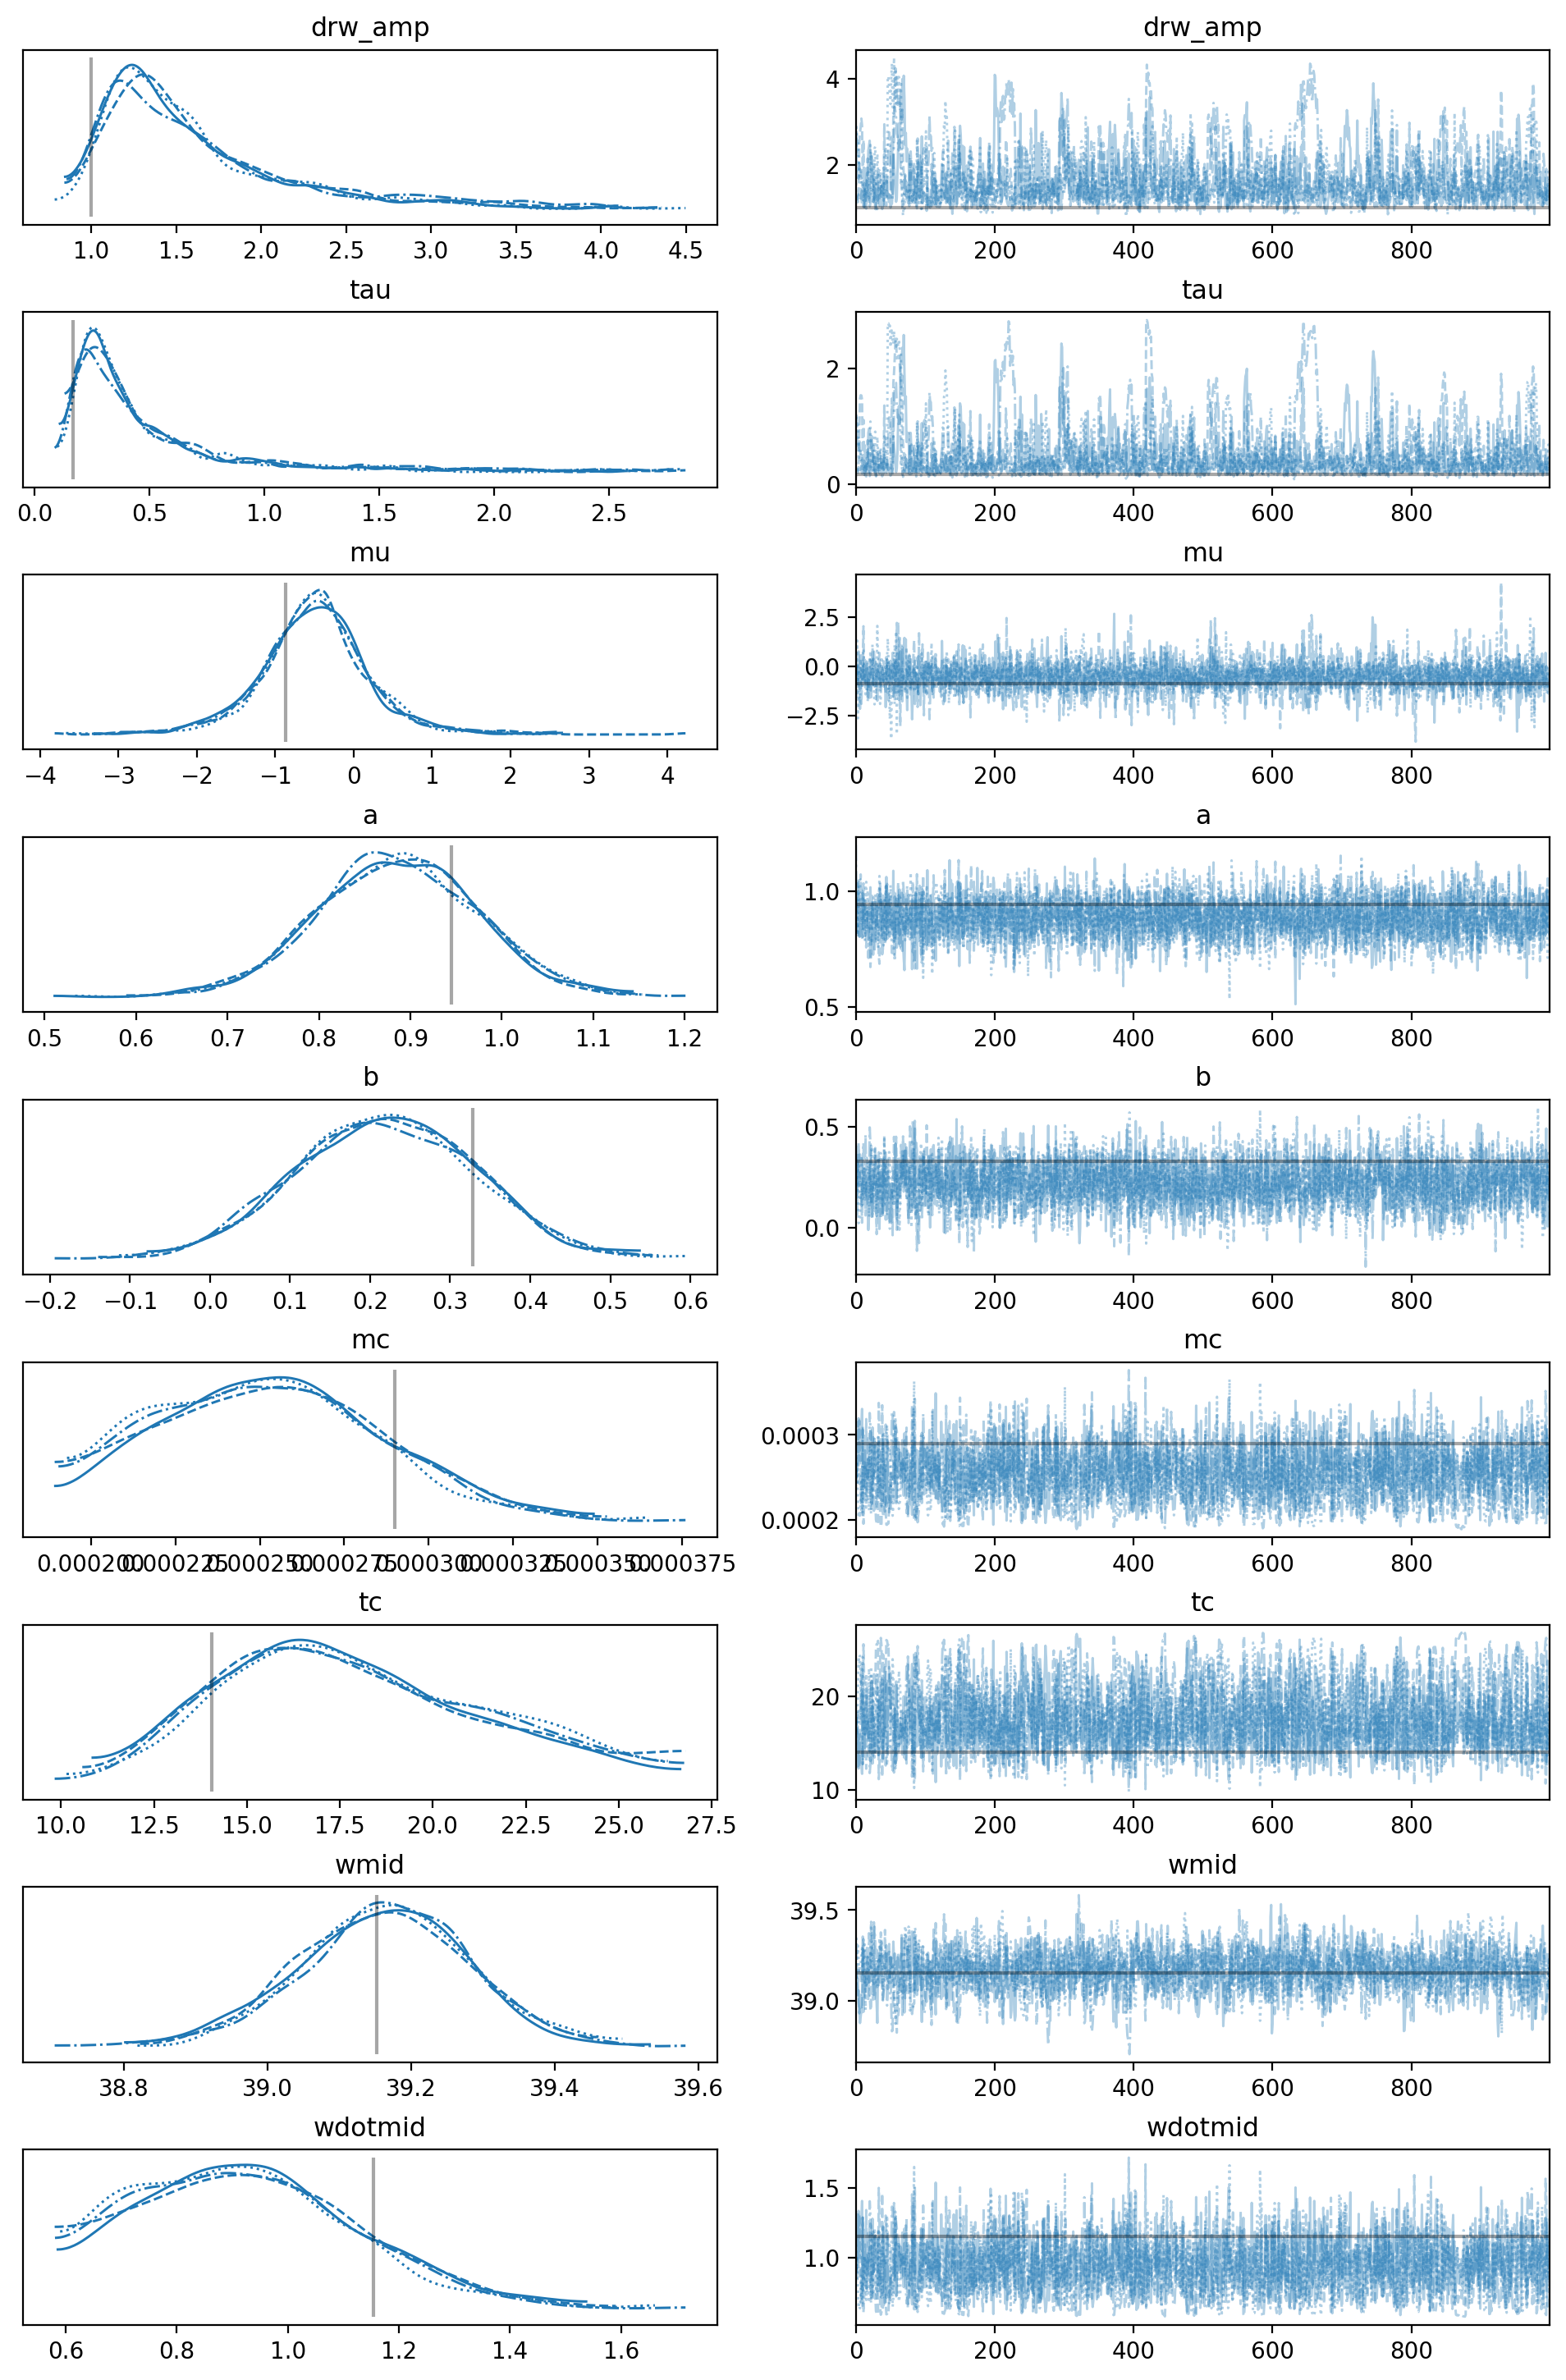

In [20]:
az.plot_trace(trace, 
              var_names=['drw_amp', 'tau', 'mu', 'a', 'b', 'mc', 'tc', 'wmid', 'wdotmid'],
              lines=[('tau', {}, drw_tau), ('wmid', {}, chirp_wmid), ('mc', {}, chirp_mass), ('drw_amp', {}, drw_amp),
                     ('a', {}, chirp_a), ('b', {}, chirp_b), ('tc', {}, chirp_time), ('wdotmid', {}, chirp_wdotmid), ('mu', {}, mu_true)])
plt.subplots_adjust(hspace=0.5)

Text(0, 0.5, 'Intensity')

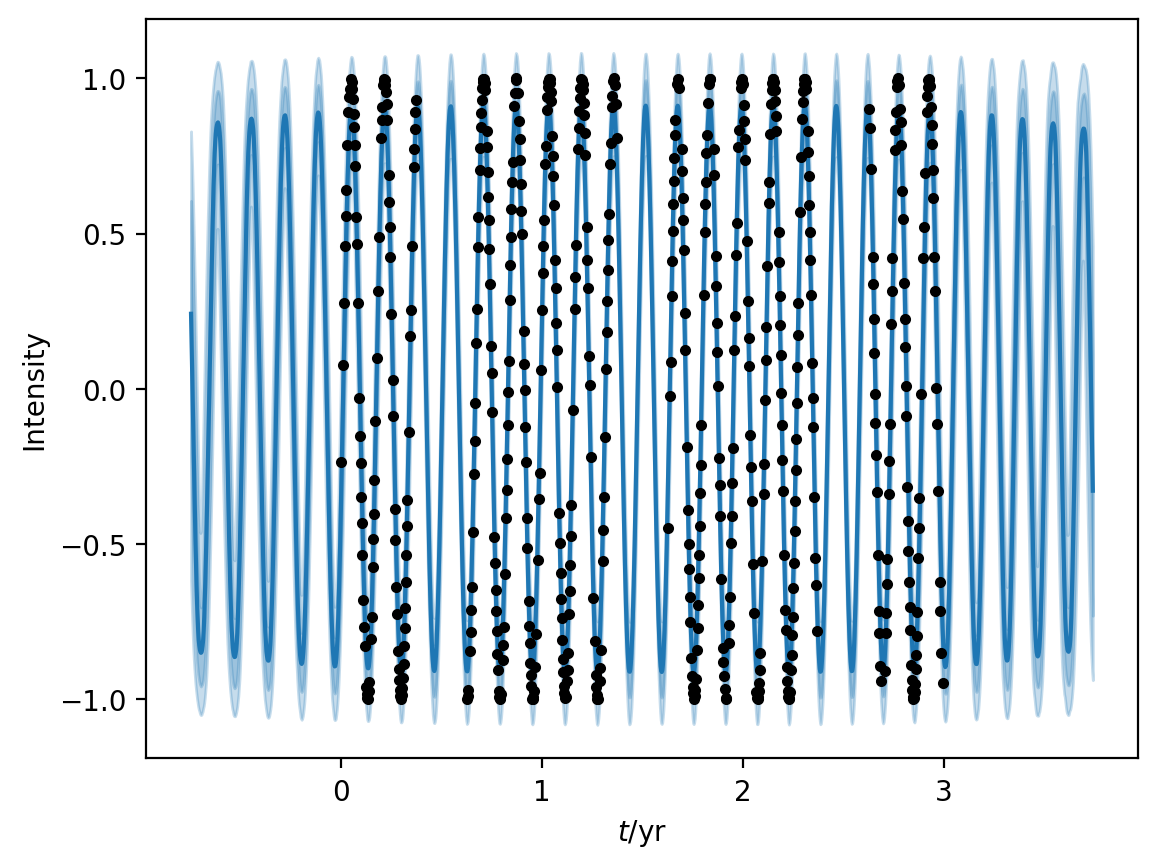

In [21]:
m = trace.posterior['chirp_signal_grid'].median(dim=['chain', 'draw'])
h = trace.posterior['chirp_signal_grid'].quantile(0.84, dim=['chain', 'draw'])
l = trace.posterior['chirp_signal_grid'].quantile(0.16, dim=['chain', 'draw'])
hh = trace.posterior['chirp_signal_grid'].quantile(0.975, dim=['chain', 'draw'])
ll = trace.posterior['chirp_signal_grid'].quantile(0.025, dim=['chain', 'draw'])

line, = plt.plot(t_grid, m, label='Chirp Model')
plt.fill_between(t_grid, l, h, color=line.get_color(), alpha=0.25)
plt.fill_between(t_grid, ll, hh, color=line.get_color(), alpha=0.25)

plt.plot(ts, chirp_signal, '.k', label='True Chirp')
plt.xlabel(r'$t / \mathrm{yr}$')
plt.ylabel(r'Intensity')

We can think of the detection significance of the chirp signal as the number of s.d. the mean amplitude is from $0$:

Text(0.5, 1.0, 'A = 0.920 +/- 0.084, S/N = 11.0')

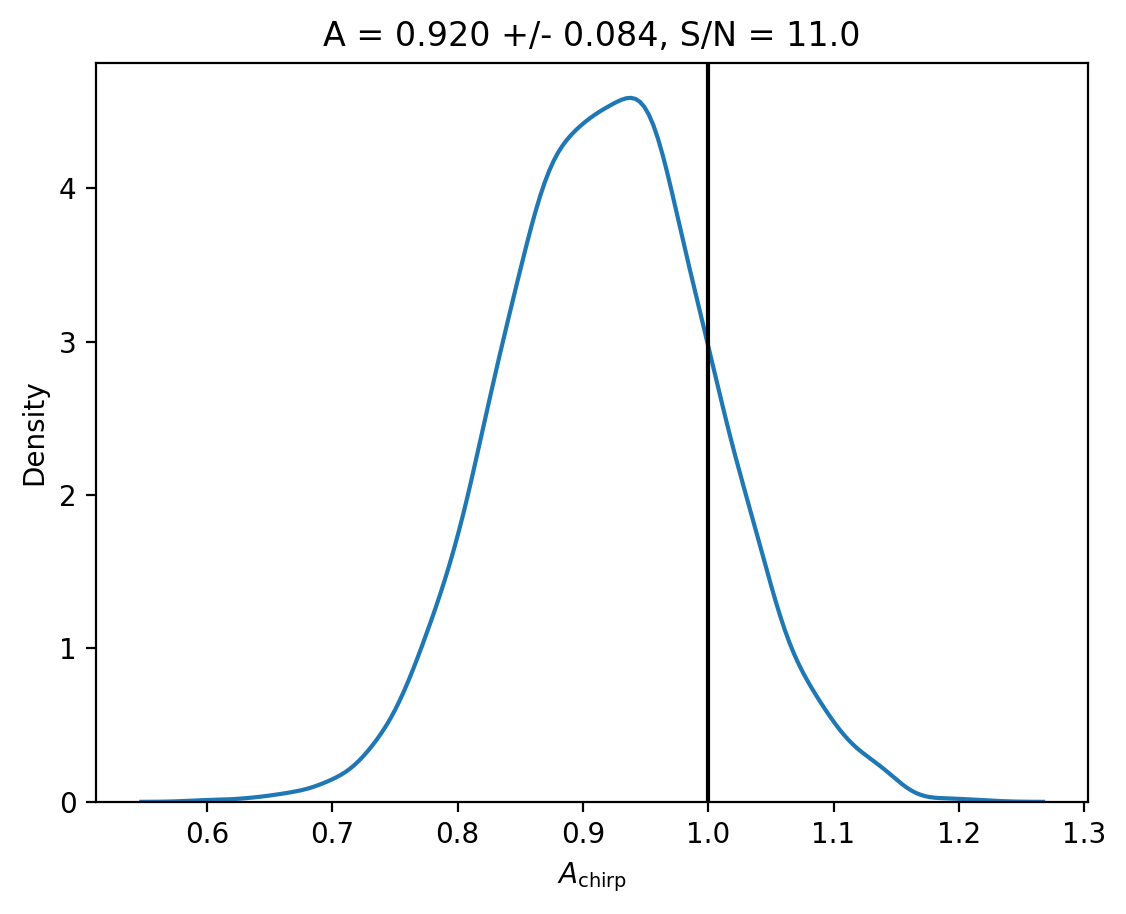

In [22]:
ca = trace.posterior.chirp_amp.values.flatten()
sns.kdeplot(ca)
plt.xlabel(r'$A_\mathrm{chirp}$')
plt.axvline(chirp_amp, color='k')
plt.title('A = {:.3f} +/- {:.3f}, S/N = {:.1f}'.format(np.mean(ca), np.std(ca), np.mean(ca)/np.std(ca)))

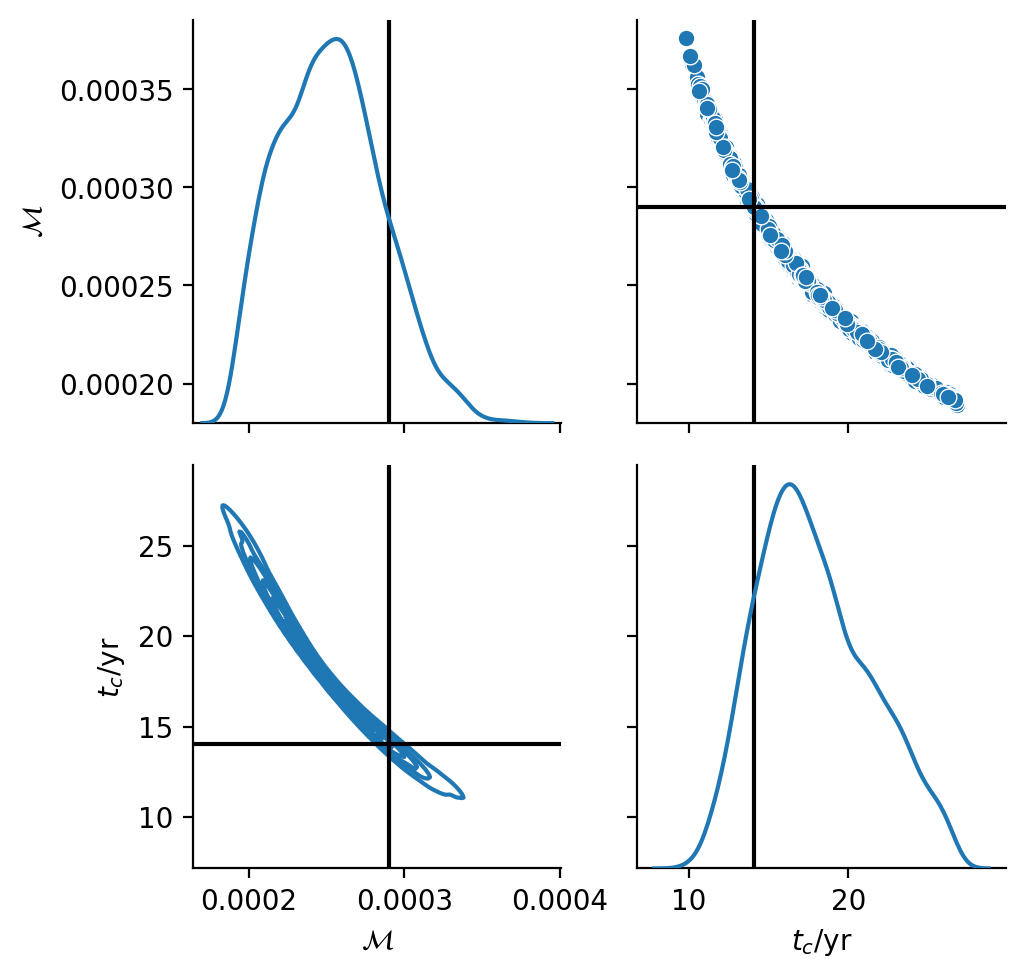

In [23]:
df = pd.DataFrame({
    r'$\mathcal{M}$': trace.posterior.mc.values.flatten(),
    r'$t_c / \mathrm{yr}$': trace.posterior.tc.values.flatten()
})

truths = [chirp_mass, chirp_time]

pg = sns.PairGrid(df, diag_sharey=False)
pg.map_diag(sns.kdeplot)
pg.map_upper(sns.scatterplot)
pg.map_lower(sns.kdeplot)

for i in range(pg.axes.shape[0]):
    for j in range(pg.axes.shape[1]):
        ax = pg.axes[i,j]

        ax.axvline(truths[j], color='k')
        if i != j:
            ax.axhline(truths[i], color='k')

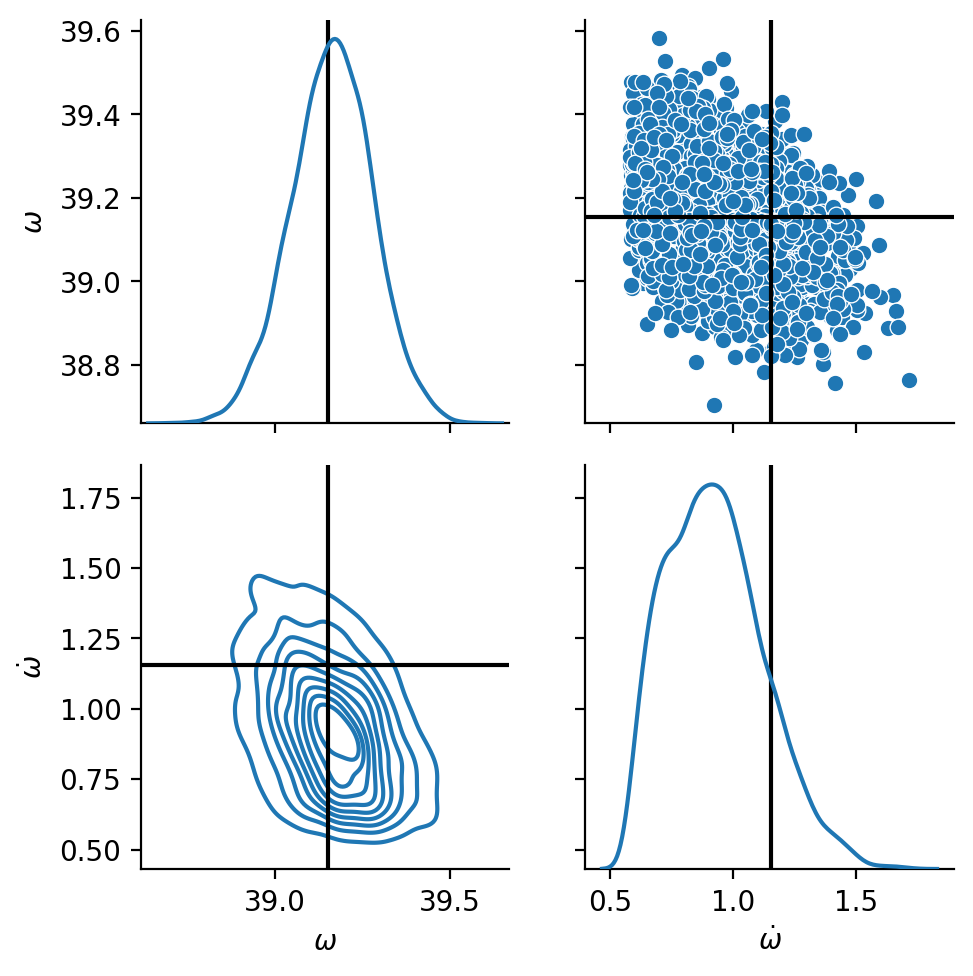

In [24]:
df = pd.DataFrame({
    r'$\omega$': trace.posterior.wmid.values.flatten(),
    r'$\dot{\omega}$': trace.posterior.wdotmid.values.flatten()
})

truths = [chirp_wmid, chirp_wdotmid]

pg = sns.PairGrid(df, diag_sharey=False)
pg.map_diag(sns.kdeplot)
pg.map_upper(sns.scatterplot)
pg.map_lower(sns.kdeplot)

for i in range(pg.axes.shape[0]):
    for j in range(pg.axes.shape[1]):
        ax = pg.axes[i,j]

        ax.axvline(truths[j], color='k')
        if i != j:
            ax.axhline(truths[i], color='k')

Here is an illustration (but it's not terribly clear?) of the effect of the grid of chirps spaced by $2\pi k / T$ in their frequency at the median time:

In [25]:
true_chirp_grid = chirp.chirp(t_grid - tmid, chirp_a, chirp_b, chirp_time - tmid, chirp_mass)
periodic_chirp_grids = []
for k in [-2, -1, 1, 2]:
    T = ts[-1]-ts[0]
    m,t = chirp.frequency_frequency_derivative_to_mc_tc(chirp_wmid + 7.72525*k/T, chirp_wdotmid)
    periodic_chirp_grids.append(chirp.chirp(t_grid - tmid, chirp_a, chirp_b, t - tmid, m))
periodic_chirp_grids = jnp.array(periodic_chirp_grids)

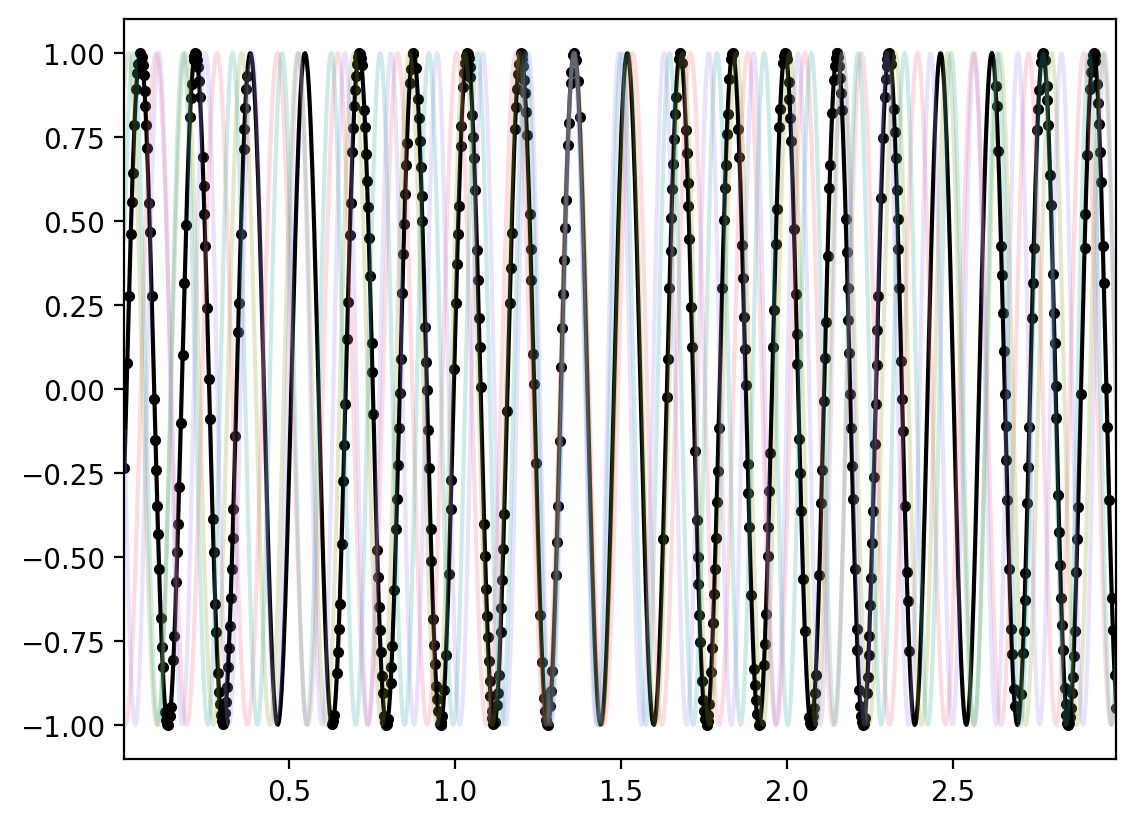

In [26]:
with sns.color_palette('husl', n_colors=periodic_chirp_grids.shape[0]):
    plt.plot(ts, chirp_signal, '.k')
    l, = plt.plot(t_grid, true_chirp_grid, 'k')
    for p in periodic_chirp_grids:
        plt.plot(t_grid, p, alpha=0.25)
    plt.xlim(ts[0], ts[-1])